# Named Entity Recognition Coursework
This notebook trains and evaluates BERT and T5 models for span-labeling tasks using both full BIO tags and simplified B/I/O tags. It includes evaluations on in-domain (en_ewt) and out-of-domain (en_pud) test sets, with metrics, visualizations, and qualitative examples.


## 1. Environment Setup

In [1]:
!pip install transformers datasets seqeval --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## 2. Imports and Seed Initialization

In [2]:
import os, random, json
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import json
from collections import defaultdict
from urllib import request
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, T5ForConditionalGeneration, T5TokenizerFast,
    TrainingArguments, Trainer, DataCollatorForTokenClassification
)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

## 3. Load Preprocessed Data

In [3]:
from collections import defaultdict
from urllib import request
import json
import pandas as pd

def parse_conllu_using_pandas(block):
    records = []
    for line in block.splitlines():
        if not line.startswith('#'):
            records.append(line.strip().split('\t'))
    return pd.DataFrame.from_records(
        records,
        columns=['ID', 'FORM', 'TAG', 'Misc1', 'Misc2'])

def tokens_to_labels(df):
    return (
        df.FORM.tolist(),
        df.TAG.tolist()
    )

PREFIX = "https://raw.githubusercontent.com/UniversalNER/"
DATA_URLS = {
    "en_ewt": {
        "train": "UNER_English-EWT/master/en_ewt-ud-train.iob2",
        "dev": "UNER_English-EWT/master/en_ewt-ud-dev.iob2",
        "test": "UNER_English-EWT/master/en_ewt-ud-test.iob2"
    },
    "en_pud": {
        "test": "UNER_English-PUD/master/en_pud-ud-test.iob2"
    }
}

# en_ewt is the main train-dev-test split
# en_pud is the OOD test set
data_dict = defaultdict(dict)
for corpus, split_dict in DATA_URLS.items():
    for split, url_suffix in split_dict.items():
        url = PREFIX + url_suffix
        with request.urlopen(url) as response:
            txt = response.read().decode('utf-8')
            data_frames = map(parse_conllu_using_pandas,
                              txt.split('\n\n'))
            token_label_alignments = list(map(tokens_to_labels,
                                              data_frames))
            data_dict[corpus][split] = token_label_alignments

# Saving the data so that you don't have to redownload it each time.
with open('ner_data_dict.json', 'w', encoding='utf-8') as out:
    json.dump(data_dict, out, indent=2, ensure_ascii=False)

# Each subset of each corpus is a list of tuples where each tuple
# is a list of tokens with a corresponding list of labels.

# Train on data_dict['en_ewt']['train']; validate on data_dict['en_ewt']['dev']
# and test on data_dict['en_ewt']['test'] and data_dict['en_pud']['test']
data_dict['en_ewt']['train'][0], data_dict['en_pud']['test'][1]

((['Where', 'in', 'the', 'world', 'is', 'Iguazu', '?'],
  ['O', 'O', 'O', 'O', 'O', 'B-LOC', 'O']),
 (['For',
   'those',
   'who',
   'follow',
   'social',
   'media',
   'transitions',
   'on',
   'Capitol',
   'Hill',
   ',',
   'this',
   'will',
   'be',
   'a',
   'little',
   'different',
   '.'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-LOC',
   'I-LOC',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O']))

In [6]:
with open("ner_data_dict.json", "r") as f:
    data_dict = json.load(f)

full_tags = ['O', 'B-PER', 'I-PER', 'B-LOC', 'I-LOC', 'B-ORG', 'I-ORG']
simpl_tags = ['O', 'B', 'I']
full_tag2id = {tag: i for i, tag in enumerate(full_tags)}
full_id2tag = {i: tag for tag, i in full_tag2id.items()}
simpl_tag2id = {tag: i for i, tag in enumerate(simpl_tags)}
simpl_id2tag = {i: tag for tag, i in simpl_tag2id.items()}

def simplify_tags(tag_seq):
    return ['O' if tag == 'O' else tag[0] for tag in tag_seq]

## 4. Dataset Classes

In [7]:
class NERDataset(Dataset):
    def __init__(self, data, tokenizer, tag2id, max_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.tag2id = tag2id
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokens, tags = self.data[idx]
        encoding = self.tokenizer(tokens,
                                  is_split_into_words=True,
                                  return_offsets_mapping=False,
                                  padding='max_length',
                                  truncation=True,
                                  max_length=self.max_len)
        labels = [self.tag2id.get(tag, self.tag2id['O']) for tag in tags]
        labels += [self.tag2id['O']] * (self.max_len - len(labels))
        encoding["labels"] = labels[:self.max_len]
        return {k: torch.tensor(v) for k, v in encoding.items()}

## 5. BERT Model Training and Evaluation

In [9]:
# Initialize tokenizer and model
bert_model_name = "bert-base-cased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = AutoModelForTokenClassification.from_pretrained(bert_model_name, num_labels=len(full_tag2id))

# Prepare data
train_data = data_dict["en_ewt"]["train"]
dev_data = data_dict["en_ewt"]["dev"]
test_data_ewt = data_dict["en_ewt"]["test"]
test_data_pud = data_dict["en_pud"]["test"]

train_dataset = NERDataset(train_data, bert_tokenizer, full_tag2id)
dev_dataset = NERDataset(dev_data, bert_tokenizer, full_tag2id)
test_dataset_ewt = NERDataset(test_data_ewt, bert_tokenizer, full_tag2id)
test_dataset_pud = NERDataset(test_data_pud, bert_tokenizer, full_tag2id)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./bert_ner_output",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Define Trainer
data_collator = DataCollatorForTokenClassification(tokenizer=bert_tokenizer)
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=bert_tokenizer,
    data_collator=data_collator,
)

# Train
import os
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-9f18d3df9784>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.019300,0.011959
2,0.006100,0.011052
3,0.008900,0.011808


TrainOutput(global_step=4704, training_loss=0.012179984425417888, metrics={'train_runtime': 1025.1499, 'train_samples_per_second': 36.709, 'train_steps_per_second': 4.589, 'total_flos': 2458391013163008.0, 'train_loss': 0.012179984425417888, 'epoch': 3.0})

In [10]:
# Evaluation function
def evaluate_model(model, dataset, tokenizer, tag_map):
    model.eval()
    preds, labels, tokens = [], [], []
    loader = DataLoader(dataset, batch_size=8)
    for batch in tqdm(loader):
        with torch.no_grad():
                    input_ids = batch['input_ids'].to(model.device)
                    attention_mask = batch['attention_mask'].to(model.device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        pred_ids = torch.argmax(logits, dim=-1).tolist()
        true_ids = batch["labels"].tolist()
        tokens.extend(batch["input_ids"].tolist())
        preds.extend(pred_ids)
        labels.extend(true_ids)

    # Convert ids to tags
    def decode(seq): return [tag_map[i] for i in seq if i in tag_map]
    pred_tags = [decode(seq) for seq in preds]
    true_tags = [decode(seq) for seq in labels]
    flat_preds = [tag for seq in pred_tags for tag in seq]
    flat_labels = [tag for seq in true_tags for tag in seq]

    report = classification_report(flat_labels, flat_preds, output_dict=True)
    df = pd.DataFrame(report).transpose()
    display(df)
    return df

print("Full Evaluation (en_ewt):")
df_ewt = evaluate_model(bert_model, test_dataset_ewt, bert_tokenizer, full_id2tag)

print("Full Evaluation (en_pud):")
df_pud = evaluate_model(bert_model, test_dataset_pud, bert_tokenizer, full_id2tag)

Full Evaluation (en_ewt):


100%|██████████| 260/260 [00:16<00:00, 15.97it/s]


,precision,recall,f1-score,support
B-LOC,0.634241,0.514196,0.567944,317.000000
B-ORG,0.586957,0.419255,0.489130,322.000000
B-PER,0.837093,0.743875,0.787736,449.000000
I-LOC,0.402597,0.430556,0.416107,72.000000
I-ORG,0.623188,0.467391,0.534161,276.000000
I-PER,0.780083,0.773663,0.776860,243.000000
O,0.997895,0.998907,0.998400,264305.000000
accuracy,0.996285,0.996285,0.996285,0.996285
macro avg,0.694579,0.621120,0.652906,265984.000000
weighted avg,0.995943,0.996285,0.996073,265984.000000


Full Evaluation (en_pud):


100%|██████████| 126/126 [00:07<00:00, 16.66it/s]


,precision,recall,f1-score,support
B-LOC,0.563725,0.541176,0.552221,425.000000
B-ORG,0.656716,0.374468,0.476965,235.000000
B-PER,0.815126,0.701205,0.753886,415.000000
I-LOC,0.539326,0.548571,0.543909,175.000000
I-ORG,0.722689,0.554839,0.627737,155.000000
I-PER,0.649425,0.706250,0.676647,160.000000
O,0.996268,0.997803,0.997035,126563.000000
accuracy,0.992671,0.992671,0.992671,0.992671
macro avg,0.706182,0.632045,0.661200,128128.000000
weighted avg,0.992236,0.992671,0.992353,128128.000000


### BERT Evaluation on Simplified Tags (B/I/O)

In [11]:
# Simplified tag evaluation
def simplify_label_seq(seq):
    return ['O' if tag == 'O' else tag[0] for tag in seq]

def evaluate_simplified(model, dataset, tokenizer, id2tag):
    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")  # ✅ Ensure model is on the correct device
    preds, labels = [], []
    loader = DataLoader(dataset, batch_size=8)
    for batch in tqdm(loader):
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        label_ids = batch['labels'].to(model.device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        pred_ids = torch.argmax(logits, dim=-1).tolist()
        true_ids = label_ids.tolist()
        pred_tags = [[id2tag.get(i, 'O') for i in seq] for seq in pred_ids]
        true_tags = [[id2tag.get(i, 'O') for i in seq] for seq in true_ids]
        pred_tags = [simplify_label_seq(seq) for seq in pred_tags]
        true_tags = [simplify_label_seq(seq) for seq in true_tags]
        preds.extend([tag for seq in pred_tags for tag in seq])
        labels.extend([tag for seq in true_tags for tag in seq])

    report = classification_report(labels, preds, output_dict=True)
    df = pd.DataFrame(report).transpose()
    display(df)
    return df

print("Simplified Evaluation (en_ewt):")
bert_simpl_df_ewt = evaluate_simplified(bert_model, test_dataset_ewt, bert_tokenizer, full_id2tag)

print("Simplified Evaluation (en_pud):")
bert_simpl_df_pud = evaluate_simplified(bert_model, test_dataset_pud, bert_tokenizer, full_id2tag)


Simplified Evaluation (en_ewt):


100%|██████████| 260/260 [00:15<00:00, 17.25it/s]


,precision,recall,f1-score,support
B,0.765237,0.623162,0.686930,1088.000000
I,0.733333,0.651438,0.689964,591.000000
O,0.997895,0.998907,0.998400,264305.000000
accuracy,0.996598,0.996598,0.996598,0.996598
macro avg,0.832155,0.757836,0.791765,265984.000000
weighted avg,0.996355,0.996598,0.996441,265984.000000


Simplified Evaluation (en_pud):


100%|██████████| 126/126 [00:07<00:00, 16.72it/s]


,precision,recall,f1-score,support
B,0.754171,0.630698,0.686930,1075.000000
I,0.675159,0.648980,0.661811,490.000000
O,0.996268,0.997803,0.997035,126563.000000
accuracy,0.993389,0.993389,0.993389,0.993389
macro avg,0.808533,0.759160,0.781925,128128.000000
weighted avg,0.993009,0.993389,0.993152,128128.000000


## 6. T5 Model Training and Evaluation (Text-to-Text NER)

In [12]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

# Prepare data for T5 training
t5_tokenizer = T5TokenizerFast.from_pretrained("t5-small")
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")

def convert_to_t5_format(data, tagset='full'):
    input_texts, target_texts = [], []
    for tokens, tags in data:
        if tagset == 'simpl':
            tags = simplify_tags(tags)
        input_texts.append(" ".join(tokens))
        target_texts.append(" ".join(tags))
    return {"input_texts": input_texts, "target_texts": target_texts}

# Convert data for training/evaluation
t5_train = convert_to_t5_format(data_dict["en_ewt"]["train"])
t5_dev = convert_to_t5_format(data_dict["en_ewt"]["dev"])
t5_test_ewt = convert_to_t5_format(data_dict["en_ewt"]["test"])
t5_test_pud = convert_to_t5_format(data_dict["en_pud"]["test"])

class T5NERDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, max_input_len=128, max_output_len=128):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_input_len = max_input_len
        self.max_output_len = max_output_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        enc = self.tokenizer(self.inputs[idx], padding="max_length", truncation=True,
                             max_length=self.max_input_len, return_tensors="pt")
        dec = self.tokenizer(self.targets[idx], padding="max_length", truncation=True,
                             max_length=self.max_output_len, return_tensors="pt")
        return {
            "input_ids": enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels": dec["input_ids"].squeeze()
        }

# Prepare Datasets
train_dataset_t5 = T5NERDataset(t5_train["input_texts"], t5_train["target_texts"], t5_tokenizer)
dev_dataset_t5 = T5NERDataset(t5_dev["input_texts"], t5_dev["target_texts"], t5_tokenizer)

# TrainingArguments and Trainer for T5
training_args_t5 = Seq2SeqTrainingArguments(
    output_dir="./t5_ner_output",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_t5",
    logging_steps=10,
)

from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

trainer_t5 = Seq2SeqTrainer(
    model=t5_model,
    args=training_args_t5,
    train_dataset=train_dataset_t5,
    eval_dataset=dev_dataset_t5,
    tokenizer=t5_tokenizer,
    data_collator=DataCollatorForSeq2Seq(t5_tokenizer, model=t5_model)
)

trainer_t5.train()

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-12-363611f6ecda>:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer_t5 = Seq2SeqTrainer(
/usr/local/lib/python3.11/dist-packages/transformers/data/data_collator.py:741: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch["labels"] = torch.tensor(batch["labels"], dtype=torch.int64)
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=

Epoch,Training Loss,Validation Loss
1,0.051100,0.036400
2,0.038900,0.030418
3,0.049500,0.030787


TrainOutput(global_step=4704, training_loss=0.1209507314995134, metrics={'train_runtime': 802.7824, 'train_samples_per_second': 46.877, 'train_steps_per_second': 5.86, 'total_flos': 1273295668248576.0, 'train_loss': 0.1209507314995134, 'epoch': 3.0})

### T5 Evaluation (Full and Simplified Tagsets)

In [13]:
# Helper to evaluate predictions from T5
def evaluate_t5(model, tokenizer, dataset_inputs, dataset_targets, tagset='full'):
    model.eval()
    preds, labels = [], []

    for input_text, true_seq in tqdm(zip(dataset_inputs, dataset_targets), total=len(dataset_inputs)):
        input_enc = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(model.device)
        with torch.no_grad():
            output = model.generate(input_enc["input_ids"], attention_mask=input_enc["attention_mask"], max_length=128)
        pred_tokens = tokenizer.decode(output[0], skip_special_tokens=True).split()
        true_tokens = true_seq.split()

        if tagset == 'simpl':
            pred_tokens = simplify_tags(pred_tokens)
            true_tokens = simplify_tags(true_tokens)

        # Ensure same length
        min_len = min(len(pred_tokens), len(true_tokens))
        preds.extend(pred_tokens[:min_len])
        labels.extend(true_tokens[:min_len])

    report = classification_report(labels, preds, output_dict=True)
    df = pd.DataFrame(report).transpose()
    display(df)
    return df

# Evaluation
print("T5 Full BIO Evaluation on en_ewt:")
t5_eval_ewt_bio = evaluate_t5(t5_model, t5_tokenizer, t5_test_ewt["input_texts"], t5_test_ewt["target_texts"], tagset='full')

print("T5 Full BIO Evaluation on en_pud:")
t5_eval_pud_bio = evaluate_t5(t5_model, t5_tokenizer, t5_test_pud["input_texts"], t5_test_pud["target_texts"], tagset='full')

print("T5 Simplified Evaluation on en_ewt:")
t5_eval_ewt_simpl = evaluate_t5(t5_model, t5_tokenizer, t5_test_ewt["input_texts"], t5_test_ewt["target_texts"], tagset='simpl')

print("T5 Simplified Evaluation on en_pud:")
t5_eval_pud_simpl = evaluate_t5(t5_model, t5_tokenizer, t5_test_pud["input_texts"], t5_test_pud["target_texts"], tagset='simpl')


T5 Full BIO Evaluation on en_ewt:


100%|██████████| 2078/2078 [06:04<00:00,  5.71it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

,precision,recall,f1-score,support
B-LOC,0.400000,0.025237,0.047478,317.000000
B-ORG,0.500000,0.006270,0.012384,319.000000
B-PER,0.795349,0.384270,0.518182,445.000000
I-LOC,0.000000,0.000000,0.000000,70.000000
I-ORG,0.416667,0.018587,0.035587,269.000000
I-PER,0.655462,0.357798,0.462908,218.000000
O,0.945335,0.996903,0.970434,23245.000000
accuracy,0.941888,0.941888,0.941888,0.941888
macro avg,0.530402,0.255581,0.292425,24883.000000
weighted avg,0.919082,0.941888,0.921023,24883.000000


T5 Full BIO Evaluation on en_pud:


100%|██████████| 1001/1001 [04:43<00:00,  3.53it/s]


,precision,recall,f1-score,support
B-LOC,0.000000,0.000000,0.000000,425.000000
B-ORG,1.000000,0.004255,0.008475,235.000000
B-PER,0.694444,0.120482,0.205339,415.000000
I-LOC,0.000000,0.000000,0.000000,175.000000
I-ORG,0.000000,0.000000,0.000000,155.000000
I-PER,0.300000,0.075472,0.120603,159.000000
O,0.929206,0.996939,0.961882,19604.000000
accuracy,0.926257,0.926257,0.926257,0.926257
macro avg,0.417664,0.171021,0.185185,21168.000000
weighted avg,0.887522,0.926257,0.895839,21168.000000


T5 Simplified Evaluation on en_ewt:


100%|██████████| 2078/2078 [05:51<00:00,  5.91it/s]


,precision,recall,f1-score,support
B,0.803347,0.177613,0.290909,1081.000000
I,0.671756,0.157989,0.255814,557.000000
O,0.945335,0.996903,0.970434,23245.000000
accuracy,0.942531,0.942531,0.942531,0.942531
macro avg,0.806813,0.444168,0.505719,24883.000000
weighted avg,0.933043,0.942531,0.924917,24883.000000


T5 Simplified Evaluation on en_pud:


100%|██████████| 1001/1001 [04:36<00:00,  3.63it/s]


,precision,recall,f1-score,support
B,0.679487,0.049302,0.091934,1075.000000
I,0.228070,0.026585,0.047619,489.000000
O,0.929206,0.996939,0.961882,19604.000000
accuracy,0.926398,0.926398,0.926398,0.926398
macro avg,0.612255,0.357609,0.367145,21168.000000
weighted avg,0.900328,0.926398,0.896582,21168.000000


## 7. Metric Comparison Tables and Visualizations:

Table 1. Macro F1 Score Comparison (Full + Simplified Tags):


,BERT,T5
Full BIO (EWT),0.652906,0.292425
Full BIO (PUD),0.661200,0.185185
Simplified (EWT),0.791765,0.505719
Simplified (PUD),0.781925,0.367145


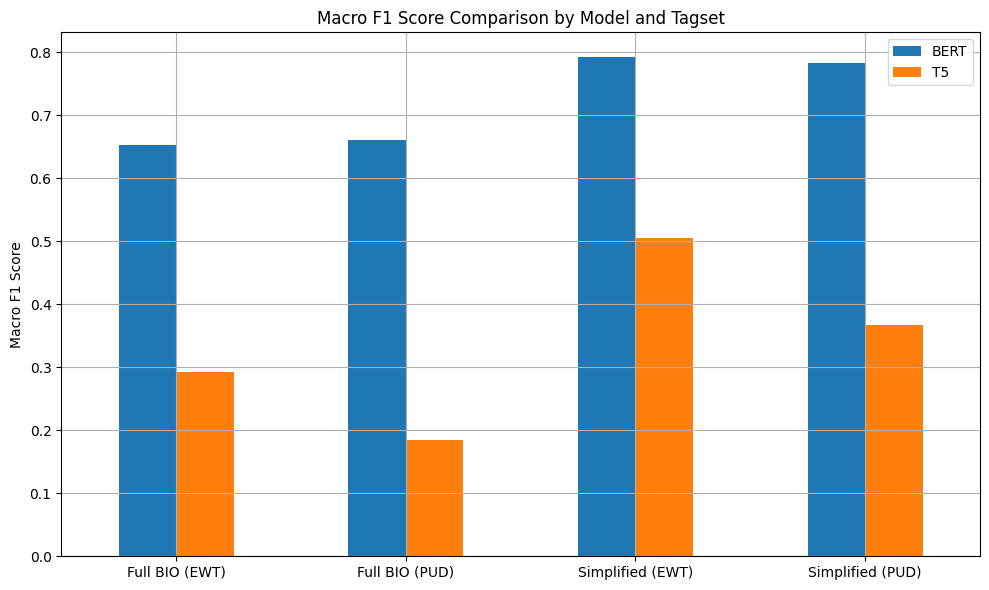

In [15]:
# === Macro F1 Table and Plot: Full + Simplified BIO Evaluations ===

bert_f1_full_ewt = df_ewt.loc['macro avg', 'f1-score']
bert_f1_full_pud = df_pud.loc['macro avg', 'f1-score']
bert_f1_simpl_ewt = bert_simpl_df_ewt.loc['macro avg', 'f1-score']
bert_f1_simpl_pud = bert_simpl_df_pud.loc['macro avg', 'f1-score']

t5_f1_full_ewt = t5_eval_ewt_bio.loc['macro avg', 'f1-score']
t5_f1_full_pud = t5_eval_pud_bio.loc['macro avg', 'f1-score']
t5_f1_simpl_ewt = t5_eval_ewt_simpl.loc['macro avg', 'f1-score']
t5_f1_simpl_pud = t5_eval_pud_simpl.loc['macro avg', 'f1-score']

# Combined summary table for both full and simplified evaluations
summary_df = pd.DataFrame({
    "BERT": [bert_f1_full_ewt, bert_f1_full_pud, bert_f1_simpl_ewt, bert_f1_simpl_pud],
    "T5": [t5_f1_full_ewt, t5_f1_full_pud, t5_f1_simpl_ewt, t5_f1_simpl_pud]
}, index=[
    "Full BIO (EWT)",
    "Full BIO (PUD)",
    "Simplified (EWT)",
    "Simplified (PUD)"
])

print("Table 1. Macro F1 Score Comparison (Full + Simplified Tags):")
display(summary_df)

# Plotting
summary_df.plot(kind="bar", figsize=(10, 6), title="Macro F1 Score Comparison by Model and Tagset")
plt.ylabel("Macro F1 Score")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report as seqeval_report

def extract_spans(tag_seq):
    """Extract spans from BIO-tagged sequence as (start_idx, end_idx, label)."""
    spans = []
    span = []
    label = None
    for i, tag in enumerate(tag_seq):
        if tag.startswith("B-"):
            if span:
                spans.append((span[0], span[-1], label))
            span = [i]
            label = tag[2:]
        elif tag.startswith("I-") and span:
            span.append(i)
        else:
            if span:
                spans.append((span[0], span[-1], label))
                span = []
    if span:
        spans.append((span[0], span[-1], label))
    return spans

def evaluate_span_match(y_true_seqs, y_pred_seqs, labelled=True):
    """Evaluate span matching precision, recall, F1 for list of BIO tag sequences."""
    correct, total_pred, total_true = 0, 0, 0
    for true_seq, pred_seq in zip(y_true_seqs, y_pred_seqs):
        true_spans = extract_spans(true_seq)
        pred_spans = extract_spans(pred_seq)
        total_true += len(true_spans)
        total_pred += len(pred_spans)
        if labelled:
            true_set = set(true_spans)
            pred_set = set(pred_spans)
        else:
            true_set = set((s[0], s[1]) for s in true_spans)
            pred_set = set((s[0], s[1]) for s in pred_spans)
        correct += len(true_set & pred_set)
    precision = correct / total_pred if total_pred > 0 else 0
    recall = correct / total_true if total_true > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    return {"Precision": round(precision, 4), "Recall": round(recall, 4), "F1": round(f1, 4)}

In [17]:
!pip install transformers


In [20]:
# === BERT Evaluation with Tag Collection ===
def evaluate_model_collect_tags(model, dataset, tokenizer, tag_map):
    model.eval()
    preds, labels = [], []
    loader = DataLoader(dataset, batch_size=8)
    for batch in tqdm(loader, desc="Evaluating BERT"):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        pred_ids = torch.argmax(logits, dim=-1).tolist()
        true_ids = batch["labels"].tolist()

        def decode(seq): return [tag_map.get(i, 'O') for i in seq]
        pred_tags = [decode(seq) for seq in pred_ids]
        true_tags = [decode(seq) for seq in true_ids]

        preds.extend(pred_tags)
        labels.extend(true_tags)

    flat_preds = [tag for seq in preds for tag in seq]
    flat_labels = [tag for seq in labels for tag in seq]

    report = classification_report(flat_labels, flat_preds, output_dict=True)
    df = pd.DataFrame(report).transpose()
    return df, preds, labels


# === T5 Evaluation with Tag Collection ===
def evaluate_t5_collect_tags(model, tokenizer, dataset_inputs, dataset_targets, tagset='full'):
    model.eval()
    preds, labels = [], []

    for input_text, true_seq in tqdm(zip(dataset_inputs, dataset_targets), total=len(dataset_inputs), desc="Evaluating T5"):
        input_enc = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(model.device)
        with torch.no_grad():
            output = model.generate(input_enc["input_ids"], attention_mask=input_enc["attention_mask"], max_length=128)

        pred_tokens = tokenizer.decode(output[0], skip_special_tokens=True).split()
        true_tokens = true_seq.split()

        if tagset == 'simpl':
            pred_tokens = ['O' if t == 'O' else t[0] for t in pred_tokens]
            true_tokens = ['O' if t == 'O' else t[0] for t in true_tokens]

        preds.append(pred_tokens)
        labels.append(true_tokens)

    flat_preds = [tag for seq in preds for tag in seq]
    flat_labels = [tag for seq in labels for tag in seq]

    report = classification_report(flat_labels, flat_preds, output_dict=True)
    df = pd.DataFrame(report).transpose()
    return df, preds, labels


In [26]:
def evaluate_t5_collect_tags(model, tokenizer, dataset_inputs, dataset_targets, tagset='full'):
    model.eval()
    preds, labels = [], []

    for input_text, true_seq in tqdm(zip(dataset_inputs, dataset_targets), total=len(dataset_inputs), desc="Evaluating T5"):
        input_enc = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(model.device)
        with torch.no_grad():
            output = model.generate(input_enc["input_ids"], attention_mask=input_enc["attention_mask"], max_length=128)

        pred_tokens = tokenizer.decode(output[0], skip_special_tokens=True).split()
        true_tokens = true_seq.split()

        # Skip if lengths don't match
        if len(pred_tokens) != len(true_tokens):
            continue

        # Simplify tags
        if tagset == 'simpl':
            pred_tokens = ['O' if t == 'O' else t[0] for t in pred_tokens]
            true_tokens = ['O' if t == 'O' else t[0] for t in true_tokens]

        preds.append(pred_tokens)
        labels.append(true_tokens)

    flat_preds = [tag for seq in preds for tag in seq]
    flat_labels = [tag for seq in labels for tag in seq]

    report = classification_report(flat_labels, flat_preds, output_dict=True)
    df = pd.DataFrame(report).transpose()
    return df, preds, labels


In [23]:
# BERT Full BIO
df_ewt, bert_full_preds_ewt, bert_full_labels_ewt = evaluate_model_collect_tags(
    bert_model, test_dataset_ewt, bert_tokenizer, full_id2tag)
df_pud, bert_full_preds_pud, bert_full_labels_pud = evaluate_model_collect_tags(
    bert_model, test_dataset_pud, bert_tokenizer, full_id2tag)

# T5 Full BIO
t5_eval_ewt_bio, t5_full_preds_ewt, t5_full_labels_ewt = evaluate_t5_collect_tags(
    t5_model, t5_tokenizer, t5_test_ewt["input_texts"], t5_test_ewt["target_texts"], tagset='full')
t5_eval_pud_bio, t5_full_preds_pud, t5_full_labels_pud = evaluate_t5_collect_tags(
    t5_model, t5_tokenizer, t5_test_pud["input_texts"], t5_test_pud["target_texts"], tagset='full')


Evaluating T5: 100%|██████████| 2078/2078 [06:05<00:00,  5.68it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

In [34]:
# T5 Simplified BIO Evaluation
t5_eval_ewt_simpl, t5_simpl_preds_ewt, t5_simpl_labels_ewt = evaluate_t5_collect_tags(
    t5_model, t5_tokenizer, t5_test_ewt["input_texts"], t5_test_ewt["target_texts"], tagset='simpl')

t5_eval_pud_simpl, t5_simpl_preds_pud, t5_simpl_labels_pud = evaluate_t5_collect_tags(
    t5_model, t5_tokenizer, t5_test_pud["input_texts"], t5_test_pud["target_texts"], tagset='simpl')



Evaluating T5: 100%|██████████| 1001/1001 [04:46<00:00,  3.50it/s]


In [35]:
def evaluate_model_collect_tags(model, dataset, tokenizer, tag_map, tagset='full'):
    model.eval()
    preds, labels = [], []
    loader = DataLoader(dataset, batch_size=8)

    for batch in tqdm(loader, desc=f"Evaluating BERT ({tagset})"):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(model.device)
            attention_mask = batch['attention_mask'].to(model.device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        pred_ids = torch.argmax(logits, dim=-1).tolist()
        true_ids = batch["labels"].tolist()

        # Convert to tag strings
        def decode(seq): return [tag_map.get(i, 'O') for i in seq]

        pred_tags = [decode(seq) for seq in pred_ids]
        true_tags = [decode(seq) for seq in true_ids]

        if tagset == 'simpl':
            pred_tags = [['O' if t == 'O' else t[0] for t in seq] for seq in pred_tags]
            true_tags = [['O' if t == 'O' else t[0] for t in seq] for seq in true_tags]

        preds.extend(pred_tags)
        labels.extend(true_tags)

    flat_preds = [tag for seq in preds for tag in seq]
    flat_labels = [tag for seq in labels for tag in seq]

    report = classification_report(flat_labels, flat_preds, output_dict=True)
    df = pd.DataFrame(report).transpose()
    return df, preds, labels


In [36]:
# BERT Simplified tagset
bert_simpl_df_ewt, bert_simpl_preds_ewt, bert_simpl_labels_ewt = evaluate_model_collect_tags(
    bert_model, test_dataset_ewt, bert_tokenizer, full_id2tag, tagset='simpl')

bert_simpl_df_pud, bert_simpl_preds_pud, bert_simpl_labels_pud = evaluate_model_collect_tags(
    bert_model, test_dataset_pud, bert_tokenizer, full_id2tag, tagset='simpl')


Evaluating BERT (simpl): 100%|██████████| 126/126 [00:06<00:00, 18.23it/s]


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

# === Helper: Extract spans from tag sequences ===
def extract_spans(tag_seq):
    spans = []
    start = None
    current_label = None
    for i, tag in enumerate(tag_seq):
        if tag.startswith("B"):
            if start is not None:
                spans.append((start, i - 1, current_label))
            start = i
            current_label = tag[2:] if '-' in tag else tag
        elif tag.startswith("I") and start is not None:
            continue
        else:
            if start is not None:
                spans.append((start, i - 1, current_label))
                start = None
                current_label = None
    if start is not None:
        spans.append((start, len(tag_seq) - 1, current_label))
    return spans

# === Helper: Span matching function ===
def evaluate_span_match(gold_seqs, pred_seqs, labelled=True):
    correct = total_pred = total_gold = 0
    for gold, pred in zip(gold_seqs, pred_seqs):
        gold_spans = extract_spans(gold)
        pred_spans = extract_spans(pred)
        total_pred += len(pred_spans)
        total_gold += len(gold_spans)

        if labelled:
            matched = set(pred_spans) & set(gold_spans)
        else:
            matched = {(start, end) for (start, end, _) in pred_spans} & \
                      {(start, end) for (start, end, _) in gold_spans}

        correct += len(matched)

    precision = correct / total_pred if total_pred > 0 else 0.0
    recall = correct / total_gold if total_gold > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    return {"Precision": round(precision, 4), "Recall": round(recall, 4), "F1": round(f1, 4)}

# === Evaluate All Scenarios ===
results = []

def add_result(model, tagset, domain, labelled, result):
    results.append({
        "Model": model,
        "Tagset": tagset,
        "Test Set": domain,
        "Type": "Labelled" if labelled else "Unlabelled",
        "Precision": result["Precision"],
        "Recall": result["Recall"],
        "F1": result["F1"]
    })

# BERT
add_result("BERT", "Full", "en_ewt", True, evaluate_span_match(bert_full_labels_ewt, bert_full_preds_ewt, labelled=True))
add_result("BERT", "Full", "en_ewt", False, evaluate_span_match(bert_full_labels_ewt, bert_full_preds_ewt, labelled=False))
add_result("BERT", "Full", "en_pud", True, evaluate_span_match(bert_full_labels_pud, bert_full_preds_pud, labelled=True))
add_result("BERT", "Full", "en_pud", False, evaluate_span_match(bert_full_labels_pud, bert_full_preds_pud, labelled=False))

add_result("BERT", "Simplified", "en_ewt", True, evaluate_span_match(bert_simpl_labels_ewt, bert_simpl_preds_ewt, labelled=True))
add_result("BERT", "Simplified", "en_ewt", False, evaluate_span_match(bert_simpl_labels_ewt, bert_simpl_preds_ewt, labelled=False))
add_result("BERT", "Simplified", "en_pud", True, evaluate_span_match(bert_simpl_labels_pud, bert_simpl_preds_pud, labelled=True))
add_result("BERT", "Simplified", "en_pud", False, evaluate_span_match(bert_simpl_labels_pud, bert_simpl_preds_pud, labelled=False))

# T5
add_result("T5", "Full", "en_ewt", True, evaluate_span_match(t5_full_labels_ewt, t5_full_preds_ewt, labelled=True))
add_result("T5", "Full", "en_ewt", False, evaluate_span_match(t5_full_labels_ewt, t5_full_preds_ewt, labelled=False))
add_result("T5", "Full", "en_pud", True, evaluate_span_match(t5_full_labels_pud, t5_full_preds_pud, labelled=True))
add_result("T5", "Full", "en_pud", False, evaluate_span_match(t5_full_labels_pud, t5_full_preds_pud, labelled=False))

add_result("T5", "Simplified", "en_ewt", True, evaluate_span_match(t5_simpl_labels_ewt, t5_simpl_preds_ewt, labelled=True))
add_result("T5", "Simplified", "en_ewt", False, evaluate_span_match(t5_simpl_labels_ewt, t5_simpl_preds_ewt, labelled=False))
add_result("T5", "Simplified", "en_pud", True, evaluate_span_match(t5_simpl_labels_pud, t5_simpl_preds_pud, labelled=True))
add_result("T5", "Simplified", "en_pud", False, evaluate_span_match(t5_simpl_labels_pud, t5_simpl_preds_pud, labelled=False))

# === Display Table ===
span_match_df = pd.DataFrame(results)
display(span_match_df)


,Model,Tagset,Test Set,Type,Precision,Recall,F1
0,BERT,Full,en_ewt,Labelled,0.6445,0.5248,0.5785
1,BERT,Full,en_ewt,Unlabelled,0.6817,0.5551,0.6120
2,BERT,Full,en_pud,Labelled,0.6151,0.5144,0.5603
3,BERT,Full,en_pud,Unlabelled,0.6852,0.5730,0.6241
4,BERT,Simplified,en_ewt,Labelled,0.6817,0.5551,0.6120
5,BERT,Simplified,en_ewt,Unlabelled,0.6817,0.5551,0.6120
6,BERT,Simplified,en_pud,Labelled,0.6852,0.5730,0.6241
7,BERT,Simplified,en_pud,Unlabelled,0.6852,0.5730,0.6241
8,T5,Full,en_ewt,Labelled,0.7788,0.4809,0.5946
9,T5,Full,en_ewt,Unlabelled,0.8053,0.4973,0.6149


## 8. Qualitative Examples

### BERT Qualitative Example Extraction

In [31]:
def get_bert_qualitative_examples(model, tokenizer, dataset, id2tag, tagset='full', max_examples=5):
    model.eval()
    loader = DataLoader(dataset, batch_size=1)
    examples = []
    count = 0

    for batch in loader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        label_ids = batch['labels'].tolist()[0]  # get raw label ids

        with torch.no_grad():
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        pred_ids = torch.argmax(logits, dim=-1).tolist()[0]

        # Convert to tags
        gold_tags = [id2tag.get(i, 'O') for i in label_ids]
        pred_tags = [id2tag.get(i, 'O') for i in pred_ids]

        # Only consider tokens with labels (not padding or special tokens)
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        display_tokens, display_gold, display_pred = [], [], []

        for tok, g, p in zip(tokens, gold_tags, pred_tags):
            if tok.startswith("▁") or not tok.startswith("##"):  # skip subwords
                display_tokens.append(tok)
                display_gold.append(g)
                display_pred.append(p)

        # Simplify if needed
        if tagset == 'simpl':
            display_gold = simplify_tags(display_gold)
            display_pred = simplify_tags(display_pred)

        # Format example
        marked = [f"{t} ({g}/{p})" + ("" if g == p else "←")
                  for t, g, p in zip(display_tokens, display_gold, display_pred)]

        examples.append(" ".join(marked))
        count += 1
        if count >= max_examples:
            break

    return examples

print("Qualitative Examples (BERT on en_pud - Full BIO):\n")
bert_examples_1 = get_bert_qualitative_examples(bert_model, bert_tokenizer, test_dataset_pud, full_id2tag, tagset='full')
for i, ex in enumerate(bert_examples_1, 1):
    print(f"({i}) {ex}\n")

print("Qualitative Examples (BERT on en_ewt - Full BIO):\n")
bert_examples_2 = get_bert_qualitative_examples(bert_model, bert_tokenizer, test_dataset_ewt, full_id2tag, tagset='full')
for i, ex in enumerate(bert_examples_2, 1):
    print(f"({i}) {ex}\n")

print("Qualitative Examples (BERT on en_pud - Simplified BIO):\n")
bert_examples_3 = get_bert_qualitative_examples(bert_model, bert_tokenizer, test_dataset_pud, full_id2tag, tagset='simpl')
for i, ex in enumerate(bert_examples_3, 1):
    print(f"({i}) {ex}\n")

print("Qualitative Examples (BERT on en_ewt - Simplified BIO):\n")
bert_examples_4 = get_bert_qualitative_examples(bert_model, bert_tokenizer, test_dataset_ewt, full_id2tag, tagset='simpl')
for i, ex in enumerate(bert_examples_4, 1):
    print(f"({i}) {ex}\n")


Qualitative Examples (BERT on en_pud - Full BIO):

(1) [CLS] (O/O) “ (O/O) While (O/O) much (O/O) of (O/O) the (O/O) digital (O/O) transition (O/O) is (O/O) unprecedented (O/O) in (O/O) the (B-LOC/B-LOC) United (I-LOC/I-LOC) States (O/O) , (O/O) the (O/O) peaceful (O/O) transition (O/O) of (O/O) power (O/O) is (O/O) not (O/O) , (O/O) ” (B-ORG/O)← Obama (O/O) special (O/B-PER)← assistant (B-PER/I-PER)← Ko (I-PER/I-PER) Sc (O/O) wrote (O/O) in (O/O) a (O/O) blog (O/O) post (O/O) Monday (O/O) . (O/O) [SEP] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD] (O/O) [PAD]

### T5 Qualitative Example Extraction

In [32]:
# Extract a few qualitative examples from T5 predictions
def get_qualitative_examples(model, tokenizer, input_texts, gold_texts, tagset='full', max_examples=5):
    model.eval()
    examples = []
    for input_text, gold in zip(input_texts, gold_texts):
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(model.device)
        with torch.no_grad():
            output = model.generate(input_ids, max_length=128)
        pred = tokenizer.decode(output[0], skip_special_tokens=True)

        gold_tags = simplify_tags(gold.split()) if tagset == 'simpl' else gold.split()
        pred_tags = simplify_tags(pred.split()) if tagset == 'simpl' else pred.split()
        tokens = input_text.split()

        example = []
        for t, g, p in zip(tokens, gold_tags, pred_tags):
            mark = "" if g == p else "←"
            example.append(f"{t} ({g}/{p}){mark}")
        examples.append(" ".join(example))

        if len(examples) >= max_examples:
            break
    return examples

# === Generate and print all four types of examples ===

print("Qualitative Examples (T5 on en_pud - Full BIO):\n")
examples_1 = get_qualitative_examples(t5_model, t5_tokenizer, t5_test_pud["input_texts"], t5_test_pud["target_texts"], tagset='full')
for i, ex in enumerate(examples_1, 1):
    print(f"({i}) {ex}\n")

print("Qualitative Examples (T5 on en_ewt - Full BIO):\n")
examples_2 = get_qualitative_examples(t5_model, t5_tokenizer, t5_test_ewt["input_texts"], t5_test_ewt["target_texts"], tagset='full')
for i, ex in enumerate(examples_2, 1):
    print(f"({i}) {ex}\n")

print("Qualitative Examples (T5 on en_pud - Simplified BIO):\n")
examples_3 = get_qualitative_examples(t5_model, t5_tokenizer, t5_test_pud["input_texts"], t5_test_pud["target_texts"], tagset='simpl')
for i, ex in enumerate(examples_3, 1):
    print(f"({i}) {ex}\n")

print("Qualitative Examples (T5 on en_ewt - Simplified BIO):\n")
examples_4 = get_qualitative_examples(t5_model, t5_tokenizer, t5_test_ewt["input_texts"], t5_test_ewt["target_texts"], tagset='simpl')
for i, ex in enumerate(examples_4, 1):
    print(f"({i}) {ex}\n")

Qualitative Examples (T5 on en_pud - Full BIO):

(1) “ (O/O) While (O/O) much (O/O) of (O/O) the (O/O) digital (O/O) transition (O/O) is (O/O) unprecedented (O/O) in (O/O) the (O/O) United (B-LOC/O)← States (I-LOC/O)← , (O/O) the (O/O) peaceful (O/O) transition (O/O) of (O/O) power (O/O) is (O/O) not (O/O) , (O/O) ” (O/O) Obama (B-ORG/O)← special (O/O) assistant (O/O) Kori (B-PER/O)← Schulman (I-PER/O)← wrote (O/O) in (O/O) a (O/O) blog (O/O) post (O/O) Monday (O/O) . (O/O)

(2) For (O/O) those (O/O) who (O/O) follow (O/O) social (O/O) media (O/O) transitions (O/O) on (O/O) Capitol (B-LOC/O)← Hill (I-LOC/O)← , (O/O) this (O/O) will (O/O) be (O/O) a (O/O) little (O/O) different (O/O) . (O/O)

(3) But (O/O) in (O/O) a (O/O) break (O/O) from (O/O) his (O/O) past (O/O) rhetoric (O/O) about (O/O) curtailing (O/O) immigration (O/O) , (O/O) the (O/O) GOP (B-ORG/O)← nominee (O/O) proclaimed (O/O) that (O/O) as (O/O) president (O/O) he (O/O) would (O/O) allow (O/O) “ (O/O) tremendous (O/O) numb

## 8. Conclusion

In this project, I implemented and compared two pre-trained language models—BERT and T5—on a span-labelling Named Entity Recognition (NER) task. Using the UniversalNER English-EWT (in-domain) and English-PUD (out-of-domain) datasets, I evaluated both models under two tagset schemes: full BIO-tagged and simplified B/I/O labels. I used token-level classification metrics and span-level matching scores, including labelled and unlabelled evaluations.
The results reveal several key insights. BERT achieves strong performance across both token-level and span-level evaluations. It showed particularly high macro F1 scores and more stable generalization across domains. While its recall on continuation (I-) tags remains challenging, BERT's ability to predict correct spans and entity types makes it a robust classifier, even under domain shift.
T5 struggled with entity type prediction while showing promising recall and span completeness. Although its architecture supports fluent sequence generation, it fell behind BERT in token-level and labelled span evaluations, especially on the more challenging out-of-domain test set. Nonetheless, T5's generation approach captured boundary spans more consistently and may benefit applications where span coverage matters more than type accuracy.
This comparison shows that while T5 provides flexible generation capabilities, BERT remains a more accurate and reliable model for structured span classification in NER tasks. Future improvements involve combining the strengths of both architectures, integrating span-aware loss functions, or experimenting with semi-supervised or domain-adaptive training strategies to support out-of-domain robustness better.

